In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

import sys

from importlib import reload

import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)s | %(name)s | %(levelname)s : %(message)s',
    level=logging.INFO,
    stream=sys.stdout
)

logger = logging.getLogger('hysped-wavenet')
logger.setLevel(logging.DEBUG)

import contextily as ctx
import geocube
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import re
import seaborn as sns
import shapely
import sklearn
import tensorflow as tf
import visualkeras
import zipfile

import wandb
wandb.login()

from functools import partial
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata, rasterize_points_radial
from IPython.display import JSON, HTML
from keras.utils.np_utils import to_categorical
from matplotlib.colors import to_rgba
from shapely.geometry import box, mapping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from tqdm.notebook import trange, tqdm
from wandb.keras import WandbMetricsLogger, WandbEvalCallback, WandbModelCheckpoint


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # configure utilization of GPUs
    try:
        for gpu in gpus:
            # memory growth setting
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.set_logical_device_configuration(
                gpu,
                [tf.config.LogicalDeviceConfiguration(memory_limit=256)]
            )
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        module_logger.error(e)


# Make numpy values easier to read.
np.set_printoptions(precision=6, suppress=True)

%matplotlib inline

wandb: Currently logged in as: stevo (hysped). Use `wandb login --relogin` to force relogin


In [2]:
def mkdir(path):
    if not os.path.isdir(path):
        if not os.path.exists(path):
            os.mkdir(path)
            
def predict_model(m, X, label_encoder):
    Y = m.predict(X)
    Y = np.argmax(Y, axis=1)
    Y = label_encoder.inverse_transform(Y)
    Y = pd.DataFrame(Y, columns=['Y_pred'])
    return Y

def plot_cm(ax, cm, labels, title='Confusion Matrix'):
    sns.heatmap(
        cm,
        annot=True,
        fmt='g',
        ax=ax,
        cmap='Blues',
        # square=True,
        xticklabels=labels,
        yticklabels=labels,
        linewidths=1,
        # annot_kws={'size': 12}
    )

    ax.set_title(title)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')

    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()

## Configuration

In [3]:
cfg = dict(
    crs = 'EPSG:5514',
    figsize = (12,12),
    data_dir = os.path.join('..', 'data', 'Sverepec_spolu_preprocessed_top4'),
    models_dir = os.path.join('..', 'models'),
    class_column = 'DRUH_DR',
    model_name = 'wavenet_top4',
    encoding_bits = 8,
    dtype = 'uint8',
    n_residual_channels = 2**8,
    n_skip_channels = 5,
    n_residual_blocks = 4,
    repeats = 2
)
cfg['project_name'] = 'hysped-%s' % cfg['model_name']

mkdir(cfg['models_dir'])
display(JSON(cfg, expanded=True))

<IPython.core.display.JSON object>

## Load data

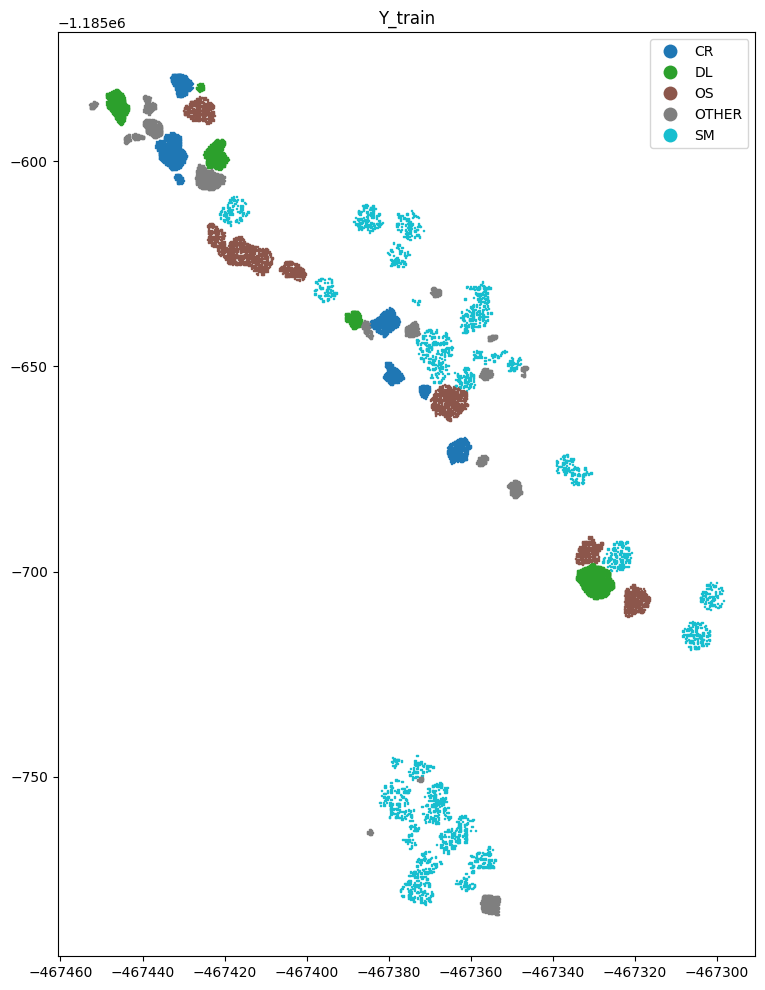

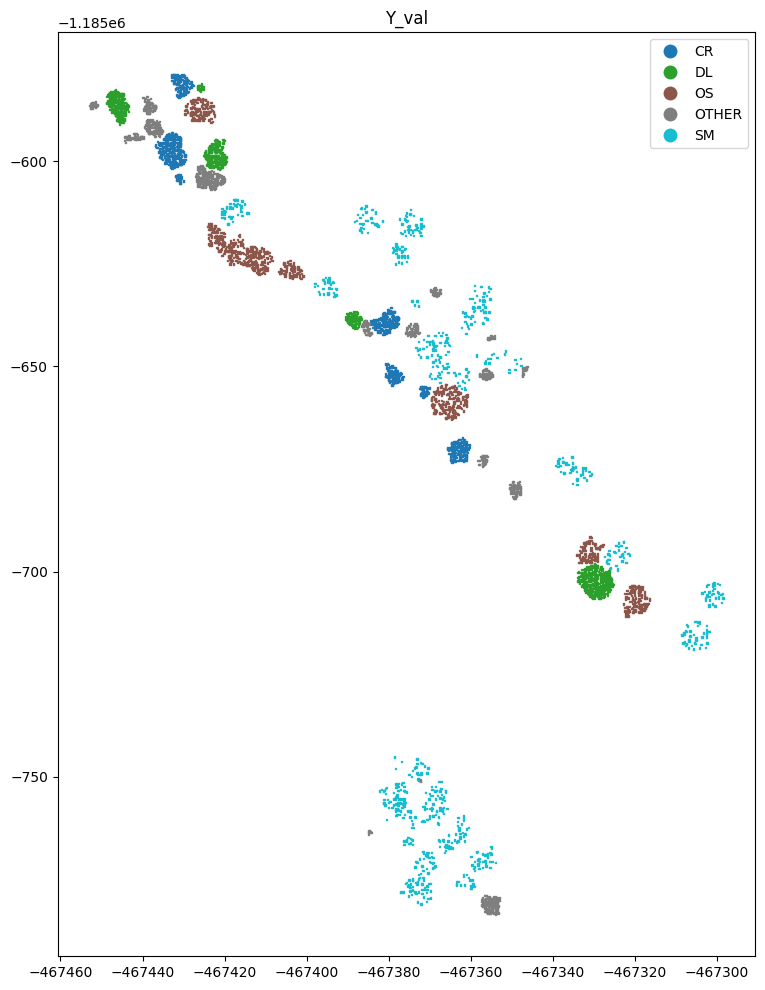

In [4]:
gdf_X_train = gpd.read_parquet(os.path.join(cfg['data_dir'], 'X_train.parquet'))
gdf_Y_train = gpd.read_parquet(os.path.join(cfg['data_dir'], 'Y_train.parquet'))
gdf_X_val = gpd.read_parquet(os.path.join(cfg['data_dir'], 'X_val.parquet'))
gdf_Y_val = gpd.read_parquet(os.path.join(cfg['data_dir'], 'Y_val.parquet'))

gdf_Y_train.plot(column=cfg['class_column'], legend=True, figsize=(12,12), marker=',', markersize=1)
plt.title('Y_train')
gdf_Y_val.plot(column=cfg['class_column'], legend=True, figsize=(12,12), marker=',', markersize=1)
plt.title('Y_val')
plt.show()

label_encoder = LabelEncoder()
encoder_filename = os.path.join(cfg['data_dir'], 'encoder-%s.npy' % cfg['class_column'])
label_encoder.classes_ = np.load(encoder_filename, allow_pickle=True)

num_classes = len(label_encoder.classes_)

X_train = gdf_X_train.values[:,1:]
X_train.resize((*X_train.shape,1))
Y_train = to_categorical(
    label_encoder.transform(gdf_Y_train[cfg['class_column']]),
    num_classes=num_classes
)

X_val = gdf_X_val.values[:,1:]
X_val.resize((*X_val.shape,1))
Y_val = to_categorical(
    label_encoder.transform(gdf_Y_val[cfg['class_column']]),
    num_classes=num_classes
)


X_train = X_train.astype(np.float32)
Y_train = Y_train.astype(np.float32)
X_val = X_val.astype(np.float32)
Y_val = Y_val.astype(np.float32)

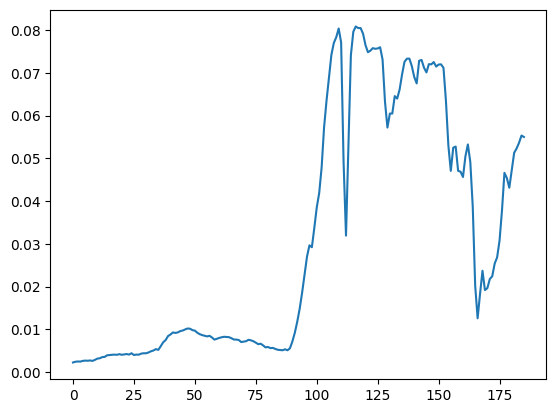

In [5]:
x = X_train
plt.plot(x[0])
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

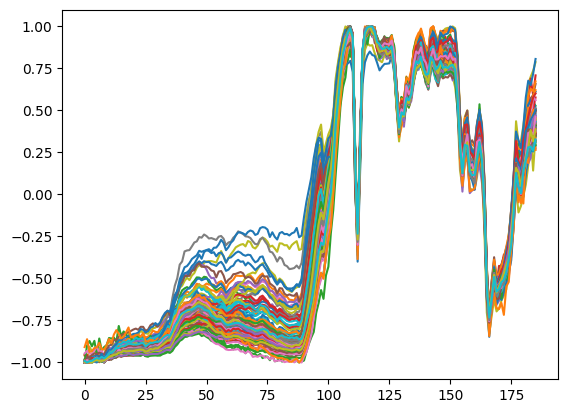

In [6]:
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1,1))
x = scaler.fit_transform(x[:,:,0].T).T
for i in tqdm(range(100)):
    plt.plot(x[i])
plt.show()

In [7]:
def norm(x, xmin=-1, xmax=1):
    scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1,1))
    return scaler.fit_transform(x.T).T, scaler

def mu_law(x, mu=255):
    return np.sign(x) * (np.log(1 + mu * np.absolute(x)) / np.log(1 + mu))

def float64_to_bin(x, xmin=-1, xmax=1, bits=8, dtype=cfg['dtype']):
    bitsmax = (2**bits) - 1
    x = ((x - xmin) / (xmax - xmin)) * bitsmax
    x = x.astype(dtype)
    return x

def one_hot(x, dim=2**cfg['encoding_bits']):
    return np.eye(dim, dtype="uint8")[x]

def preprocess(x, plot=False, plot_id=0):
    x_norm, scaler = norm(x)
    x_norm_mu = mu_law(x_norm)
    x_norm_mu_bin = float64_to_bin(x_norm_mu, bits=cfg['encoding_bits'], dtype=cfg['dtype'])
    X_train_norm_mu_bin_1hot = one_hot(x_norm_mu_bin, dim=2**cfg['encoding_bits'])
    if plot:
        plt.plot(x_norm[plot_id], label='norm')
        plt.plot(x_norm_mu[plot_id], label='mu')
        plt.legend()
        plt.show()
        plt.plot(x_norm_mu_bin[plot_id], label='%d-bit' % cfg['encoding_bits'])
        plt.legend()
        plt.show()
    return X_train_norm_mu_bin_1hot

In [8]:
X_train_p = preprocess(X_train[:,:,0])
X_val_p = preprocess(X_val[:,:,0])

print('X_train_p.shape: %s' % str(X_train_p.shape))
print('X_val_p.shape: %s' % str(X_val_p.shape))

X_train_p.shape: (10115, 186, 256)
X_val_p.shape: (4335, 186, 256)


## Model architecture

In [9]:
def wavenet(
    name: str,
    input_shape: tuple,
    num_classes: int,
    n_residual_channels: int,
    n_skip_channels: int,
    n_residual_blocks: int,
    n_stacks: int,
    **kwargs
):
    """WaveNet model
    
         input
           |
     [input_conv1D]
           |
      [residual_1]----+
           |          |
          ...         |
           |          |
      [residual_n]--+ |
                    | |
        +-----------+ |
        |   +---------+
        |...| <- skip connections
         \ /
        [ + ]
          |
  [1x1 out_conv1D_1]
          |
  [1x1 out_conv1D_2]
          |
      [softmax]
          |
        output




    Residual Block:
    
               input
                 |
    +--------+---+---+
    |        |       |
    |     [causal [causal
    |     dilated dilated
    |     conv1D] conv1D]
    |        |       |
    |      [tanh]  [sigm]
    |        |       |
    |        +->[*]<-+
    |            |
    |            +---->[1x1 skip_conv1D]--> skip connection
    |            |
    |       [1x1 conv1D]
    |            |
    +---------->[+]
                 |
              output*
    
    * output of the last residual block in the WaveNet is not connected

    """
    logger.debug('name:                      %s', name)
    logger.debug('input_shape:               %s', input_shape)
    logger.debug('n_residual_channels:       %s', n_residual_channels)
    logger.debug('n_skip_channels:           %s', n_skip_channels)
    logger.debug('n_residual_blocks:         %s', n_residual_blocks)
    logger.debug('n_stacks:                  %s', n_stacks)

    conv1D_kernel_regularizer = None
    if 'conv1D_kernel_regularizer' in kwargs:
        conv1D_kernel_regularizer = kwargs['conv1D_kernel_regularizer']
    
    n_channels = input_shape[-1]
    
    layer_input = tf.keras.layers.Input(
        shape=input_shape,
        name='input'
    )
    
    x = layer_input
    x = tf.keras.layers.BatchNormalization()(x)
    layer_input = x

    logger.debug('input_conv1D [IN]:         %s', layer_input.shape)
    input_conv1D = tf.keras.layers.Conv1D(
        n_residual_channels, # filters
        2,                   # kernel_size
        padding='causal',
        activation=None,
        kernel_regularizer=conv1D_kernel_regularizer,
        name='input_conv1D'
    )(layer_input)
    input_conv1D = tf.slice(input_conv1D, [0,1,0], [-1,-1,-1])
    logger.debug('input_conv1D [OUT]:        %s', input_conv1D.shape)
    
    res_input = input_conv1D
    
    dilation_rates = [2**i for i in range(n_residual_blocks)] * n_stacks if 'dilation_rates' not in kwargs.keys() else kwargs['dilation_rates']
    logger.debug('dilation_rates:            %s', dilation_rates)
    logger.debug('residuals:                 %s', len(dilation_rates))

    skips = []
    logger.debug('building residuals')
    for i in range(1, 1 + len(dilation_rates)):
        #
        # --> residual
        #
        
        dilation_rate = dilation_rates[i-1]
        
        # causal dilated convolution - filter
        res_filter = tf.keras.layers.Conv1D(
            n_residual_channels,
            2,
            dilation_rate=dilation_rate,
            padding='causal',
            activation=tf.nn.tanh,
            kernel_regularizer=conv1D_kernel_regularizer,
            name='residual_%03d_filter' % i
        )(res_input)
        res_filter = tf.slice(res_filter, [0,dilation_rate,0], [-1,-1,-1])

        # causal dilated convolution - gate
        res_gate = tf.keras.layers.Conv1D(
            n_residual_channels,
            2,
            dilation_rate=dilation_rate,
            padding='causal',
            activation=tf.nn.sigmoid,
            kernel_regularizer=conv1D_kernel_regularizer,
            name='residual_%03d_gate' % i
        )(res_input)
        res_gate = tf.slice(res_gate, [0,dilation_rate,0], [-1,-1,-1])

        # multiply filter and gate
        mul = tf.keras.layers.Multiply(
            name='residual_%03d_multiply_filter_gate' % i
        )([
            res_filter,
            res_gate
        ])

        # skip connection
        skip = tf.keras.layers.Conv1D(
            n_skip_channels,
            1,
            padding='same',
            activation=None,
            kernel_regularizer=conv1D_kernel_regularizer,
            name='skip_connection_%03d' % i
        )(mul)
        skip = skip[:,np.sum(dilation_rates[i:]) if i < len(dilation_rates) else 0:,:]
        skips.append(skip)
        
        # residual output as input to the next residual
        res_input_add = tf.slice(res_input, [0,dilation_rate,0], [-1,-1,-1])
        res_output = tf.keras.layers.Add(
            name='residual_%03d_output' % i,
        )([
            res_input_add,
            tf.keras.layers.Conv1D(
                n_residual_channels,
                1,
                padding='same',
                activation=None,
                kernel_regularizer=conv1D_kernel_regularizer
            )(mul)
        ])
        
        logger.debug('RESIDUAL %3d' % (i))
        logger.debug('  dilation_rate:     %d', dilation_rate)
        logger.debug('  res_input:         %s', res_input.shape)
        logger.debug('  res_filter:        %s', res_filter.shape)
        logger.debug('  res_gate:          %s', res_gate.shape)
        logger.debug('  mul:               %s', mul.shape)
        logger.debug('  skip:              %s', skip.shape)
        logger.debug('  res_output:        %s', res_output.shape)

        res_input = res_output
        #
        # <-- residual
        #
    
    logger.debug('SKIP CONNECTIONS:')
    for skip in skips:
        logger.debug('\t%s: %s', skip.name, skip.shape)
        
    # add skip connections
    skips_add = tf.keras.layers.Add(
        name='skips_add'
    )(skips)
    logger.debug('skips_add:           %s', skips_add.shape)
    
    # relu1
    relu1 = tf.keras.layers.Activation(tf.nn.relu, name='relu1')(skips_add)
    logger.debug('relu1:               %s', relu1.shape)

    #1x1 conv1 + relu2
    out_conv1D_1 = tf.keras.layers.Conv1D(
        n_channels,      # filters
        relu1.shape[1],  # kernel size
        padding='same',
        activation=None,
        kernel_regularizer=conv1D_kernel_regularizer,
        name='out_conv1D_1'
    )(relu1)
    logger.debug('out_conv1D_1:        %s', out_conv1D_1.shape)
    
    # relu2
    relu2 = tf.keras.layers.Activation(tf.nn.relu, name='relu2')(out_conv1D_1)
    logger.debug('relu2:               %s', relu2.shape)
    
    # 1x1 conv2
    out_conv1D_2 = tf.keras.layers.Conv1D(
        num_classes,
        relu2.shape[1],
        padding='same',
        activation=None,
        kernel_regularizer=conv1D_kernel_regularizer,
        name='out_conv1D_2'
    )(relu2)
    logger.debug('out_conv1D_2:        %s', out_conv1D_2.shape)
        
    layer_output = tf.cast(
        tf.keras.activations.softmax(
            tf.cast(
                out_conv1D_2,
                tf.float64
            )
        ),
        tf.float32
    )

    # layer_output = tf.slice(
    #     layer_output,
    #     [0,layer_output.shape[1]-1,0], # last
    #     [-1,-1,-1]
    # )
    layer_output = layer_output[:,-1,:]  # last - the pythonic way
    logger.debug('layer_output:        %s', layer_output.shape)
        
    model = tf.keras.models.Model(
        name=name,
        inputs=[layer_input],
        outputs=[layer_output]
    )
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    
    return model

## Train model

In [ ]:
config = dict(
    name='hysped-wavenet',
    input_shape=X_train_p.shape[1:],
    num_classes=Y_train.shape[1],
    n_residual_channels = X_train_p.shape[-1],
    n_skip_channels = 3,
    n_residual_blocks = 4,
    n_stacks = 1,
    #dilation_rates = [i for i in range(1,11)],
)

model = wavenet(**config)
model.summary()
history = model.fit(
    x=X_train_p,
    y=Y_train,
    validation_data=(X_val_p, Y_val),
    epochs=50,
    shuffle=True,
    batch_size=128,
    verbose=1
)

tf.keras.utils.plot_model(
    model,
    expand_nested=True,
    show_shapes=True,
    show_layer_activations=True
)

In [ ]:
config = dict(
    name='hysped-wavenet',
    input_shape = X_train_p.shape[1:],
    num_classes = Y_train.shape[1],
    n_residual_channels = X_train_p.shape[-1],
    n_skip_channels = 3,
    n_residual_blocks = 7,
    n_stacks = 1,
    conv1D_kernel_regularizer = 'l2',
    dilation_rates = [i for i in range(1,8)] + [i for i in range(1,5)],
)

run = wandb.init(
    project=cfg['project_name'],
    config=config,
)
logger.info('run.id: %s, run.name: %s' % (run.id, run.name))

model = wavenet(**run.config)
model.summary()

model_dir = os.path.join(cfg['models_dir'], cfg['model_name'])
mkdir(model_dir)
logger.info('model_dir: %s' % model_dir)
model_file = os.path.join(model_dir, 'run_%s_model.h5' % (run.id))
logger.info('model_file: %s' % model_file)

wandbModelCheckpoint = WandbModelCheckpoint(
    model_file,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True
)

callbacks = [
    WandbMetricsLogger(),
    wandbModelCheckpoint,
]

history = model.fit(
    x=X_train_p,
    y=Y_train,
    validation_data=(X_val_p, Y_val),
    epochs=100,
    shuffle=True,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)

run.finish()
wandb.finish()